# 非线性特征化
**第六章中PCA降维技术关注的是线性特征**

如果线性子空间称作“平面”的话 非线性子空间可以称之为“流形”

假定流形比它所在的全维度空间简单 那么就可以降维到一个更少的维度空间上去

大的流形虽然复杂 但是每个数据点邻近的区域通常可以近似为一个平面 换言之 可以通过多个小平面使用局部结构组成全局结构

非线性数据降维也称为“非线性嵌入” 或者 “流行学习”

降低维度的本质目的还是为当前数据找到最正确的特征 在非线性层面 正确的特征是表示出数据的空间特性的特征

如果使用聚类的方法 将一些点聚为一个簇 如果簇的数量小于初始特征数量 那么这种新表示就是更好的表示方法
数据就被压缩到了一个更低维度的空间上去

# K-Means聚类
聚类是一种非监督学习的方法 它不需要任何形式的标签 这种算法的目的就是仅基于数据本身推测出簇标签

聚类算法依赖于度量方式 即数据点之间相近程度的测量 一般可以使用欧氏距离 l2范数等

K-means的逻辑是每个数据点都属于且只属于一个簇 该算法通过学习簇中心点 使得欧氏距离之和最小

In [ ]:
# k-means实践

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [2]:
import matplotlib.pyplot as plt

In [3]:
n_data = 1000
seed = 1
n_cluster = 4

In [4]:
blobs, blob_labels = make_blobs(n_samples=n_data,n_features=2,centers=n_cluster,random_state=seed)

In [6]:
blobs.shape

(1000, 2)

In [10]:
blob_labels.shape

(1000,)

In [11]:
cluster_blob = KMeans(n_clusters=n_cluster,random_state=seed).fit_predict(blobs)

In [12]:
uniform = np.random.rand(n_data,2)
cluster_uniform = KMeans(n_clusters=n_cluster, random_state=seed).fit_predict(uniform)

(-0.04949811082798715,
 1.0491417680395916,
 -0.0482915663057184,
 1.0475772826570195)

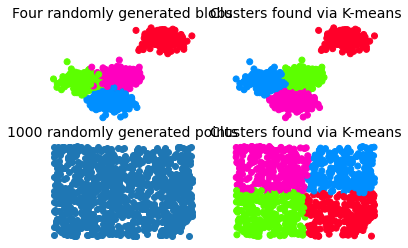

In [13]:
figure = plt.figure()
plt.subplot(221)
plt.scatter(blobs[:,0], blobs[:,1],c=blob_labels,cmap='gist_rainbow')
plt.title("Four randomly generated blobs", fontsize = 14)
plt.axis('off')

plt.subplot(222)
plt.scatter(blobs[:,0], blobs[:,1],c=cluster_blob,cmap='gist_rainbow')
plt.title("Clusters found via K-means", fontsize = 14)
plt.axis('off')

plt.subplot(223)
plt.scatter(uniform[:,0], uniform[:,1])
plt.title("1000 randomly generated points", fontsize = 14)
plt.axis('off')

plt.subplot(224)
plt.scatter(uniform[:,0], uniform[:,1], c= cluster_uniform,cmap='gist_rainbow')
plt.title("Clusters found via K-means", fontsize = 14)
plt.axis('off')

# 聚类补充
一般的聚类应用假定在数据中心可以找到自然形成的簇 即空间中有些部分集中 成为簇 有些地方空旷 如上图1,2

而为了确定分成几簇 需要选择k这个聚类索引参数

但是当数据分布十分均匀的时候 如上图3,4 就没有绝对意义上的正确的簇数了

这时聚类的效果就是**矢量量化** 即将数据划分为有限数目的数据段

这种情况下K-means就相当于用补丁来覆盖数据曲面

In [ ]:
# 矢量量化实践

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets

In [16]:
x,color = datasets._samples_generator.make_swiss_roll(n_samples=1500)

In [19]:
x.shape

(1500, 3)

In [18]:
cluster_swiss_roll = KMeans(n_clusters=100,random_state=1).fit_predict(x)

/home/wy/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


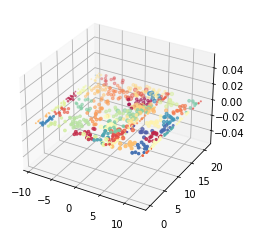

In [21]:
fig2 = plt.figure()
plt.subplot(111,projection='3d')
plt.scatter(x[:,0], x[:,1], x[:,2], c=cluster_swiss_roll, cmap='Spectral')

# k-means使用了100个簇 对其进行填充 也就是矢量量化

In [22]:
cluster_swiss_roll_2 = KMeans(n_clusters=10,random_state=1).fit_predict(x)

/home/wy/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


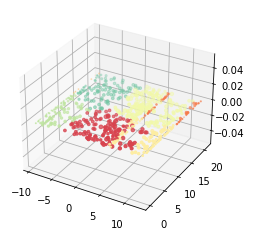

In [23]:
fig3 = plt.figure()
plt.subplot(111,projection='3d')
plt.scatter(x[:,0], x[:,1], x[:,2], c=cluster_swiss_roll_2, cmap='Spectral')

均匀分布是k-means最差的情况 如果数据密度不均匀那么就可以用较少的簇表征更多数据

# k-means与分类问题
聚类算法可以分析数据的空间分布 因此 k-means可以生成数据压缩空间的索引 供后续功能或者模型使用
这就是一个**模型堆叠**的例子

k-means可以带目标信息也可以不带目标信息 带了目标信息会聚焦于目标变量之间平衡相似度

In [ ]:
# 对比使用目标信息与不使用目标信息的k-means

In [26]:
# 作者实现的

class KMeansFeaturizer:
    """将数字型数据输入k-均值聚类.
    在输入数据上运行k-均值并且把每个数据点设定为它的簇id. 如果存在目标变量，则将其缩放并包含为k-均值的输入，以导出服从分类边界以及组相似点的簇。
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state

    def fit(self, X, y=None):
    #在输入数据上运行k-均值，并找到中心
        if y is None:
            # 没有目标变量运行k-均值
            km_model = KMeans(n_clusters=self.k,n_init=20,random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # 有目标信息，使用合适的缩减并把输入数据输入k-均值
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # 在数据和目标上简历预训练k-均值模型
        km_model_pretrain = KMeans(n_clusters=self.k,n_init=20,random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        #运行k-均值第二次获得簇在原始空间没有目标信息。使用预先训练中发现的质心进行初始化。
        #通过一个迭代的集群分配和质心重新计算。
        km_model = KMeans(n_clusters=self.k,init=km_model_pretrain.cluster_centers_[:,:2],n_init=1,max_iter=1)
        km_model.fit(X)
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self

    def transform(self, X, y=None):
    # 为每个输入数据点输出最接近的簇id。
        clusters = self.km_model.predict(X)
        return clusters[:,np.newaxis]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [24]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons

In [25]:
training_data, training_labels = make_moons(n_samples=2000,noise=0.2)

In [32]:
training_data.shape

(2000, 2)

In [27]:
kmf_hint = KMeansFeaturizer(k=100, target_scale=10).fit(training_data,training_labels)
kmf_no_hit = KMeansFeaturizer(k=100, target_scale=0).fit(training_data,training_labels)

In [35]:
kmf_hint_cluster = kmf_hint.transform(training_data,training_labels)
kmf_no_hint_cluster = kmf_no_hit.transform(training_data,training_labels)

In [37]:
kmf_hint_cluster.shape

(2000, 1)

In [28]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """绘制与数据叠加的k-均值聚类的Voronoi图"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

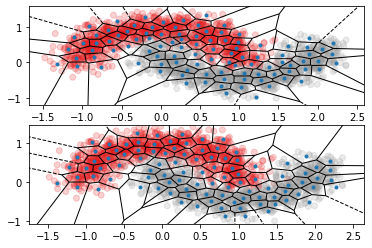

In [38]:
figure3 = plt.figure()
ax1 = figure3.add_subplot(211)
ax2 = figure3.add_subplot(212)

kmeans_voronoi_plot(training_data,training_labels,kmf_hint.cluster_centers_, ax=ax1)
kmeans_voronoi_plot(training_data,training_labels,kmf_no_hit.cluster_centers_, ax=ax2)

In [ ]:
# 测试k-means对不同分类算法的影响

In [57]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import scipy

In [40]:
# 使用和训练数据相同的分布生成一些测试数据
test_data, test_labels = make_moons(n_samples=2000, noise=0.3)

In [42]:
# 使用k-means生成器生成簇特征
training_cluster_feature = kmf_hint.transform(training_data)
test_cluster_feature = kmf_hint.transform(test_data)
# 用训练数据训练的聚类器 作用在测试数据上 防止数据泄漏

In [47]:
training_cluster_feature.shape

(2000, 1)

In [50]:
np.hstack((training_data,training_cluster_feature)).shape

(2000, 3)

In [51]:
training_with_cluster = np.hstack((training_data,training_cluster_feature))

In [52]:
test_with_cluster = np.hstack((test_data,test_cluster_feature))

# [2000,2]和[2000,1]拼接起来 变成[2000,3]
# 这样信息就是初始的坐标+它们的分类信息

In [60]:
test_cluster_feature

array([[61],
       [49],
       [12],
       ...,
       [54],
       [43],
       [74]], dtype=int32)

In [53]:
lr_cluster = LogisticRegression(random_state=seed).fit(training_with_cluster,training_labels)
# 训练模拟带簇特征的

In [54]:
classifier_names = ['LR','KNN','RBF SVM','RANDOM FOREST','BOOSTED TREES']

In [55]:
classifiers = [
    LogisticRegression(random_state=seed),
    KNeighborsClassifier(5),
    SVC(gamma=2,C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GradientBoostingClassifier(n_estimators=10,learning_rate=1.0,max_depth=5)
]

In [56]:
for model in classifiers:
    model.fit(training_data,training_labels)

In [58]:
# 使用roc评价分类性能
def test_roc(model, data, lables):
    if hasattr(model,"decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = sklearn.metrics.roc_curve(lables,predictions)
    return fpr, tpr

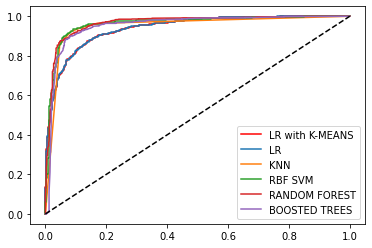

In [59]:
plt.figure()
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
# 带簇特征的
plt.plot(fpr_cluster,tpr_cluster,'r-',label='LR with K-MEANS')

for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model,test_data,test_labels)
    # 都是不带簇特征的
    plt.plot(fpr,tpr,label=classifier_names[i])
plt.plot([0,1],[0,1],'k--')
plt.legend()

In [ ]:
# roc受试者工作特征 曲线 表示的是当改变分类决策边界时真阳性和假阳性之间的权衡
# 好的分类器应该快速达到高的真阳性和低的假阳性
# 所以越靠近左上角越好

In [ ]:
# 可以看出 簇特征+逻辑回归 比单逻辑回归好得多
# 甚至于带了簇特征之后 线性模型逻辑回归近似于非线性模型了

如果不使用类似于one-hot这种聚类方式进行聚类 还可以使用密集向量来表示数据点

密集向量就是数据点到簇中心的倒数 这样会导致表示十分密集

one-hot是轻量的稠密的 但是需要很大的k 倒数法是密集的但是可以使用小一点k

# k-means优点 缺点 与 陷阱
模型堆叠的核心思想先用复杂的基础层(往往是很昂贵的模型) 生成良好的特征 再用简单快速的顶层模型组合起来(通常是线性的)
这样可以实现模型准确率和速度的正确平衡

K-means适合实数型 有界的 能在空间中聚成块状密集区域的数值特征 可以通过簇来降低维度

K-means不能处理欧式空间无效的特征空间即分布特征数值型变量或分类变量

对于上述问题有几种处理方法：
1. 尽在实数型有界的数值特征上使用K-means
2. 自定义度量方式 用以度量无法用实数距离度量的值 再用k-means
3. 将分离变量转换为分箱计数统计 再使用k-means